# Customer Segmentation for Credit Card Customers

---
## 0. Imports

In [864]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42

---
## Phase 1 — Data Exploration & Preprocessing

### 1.1 Load & Inspect

In [865]:
df = pd.read_csv('CC GENERAL.csv')
print(f'Shape: {df.shape}')
df.head()

Shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [866]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   str    
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHASES_TRX    

In [867]:
df.describe().T.style.background_gradient(subset=['mean','std','50%'])

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.000000,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.138560
BALANCE_FREQUENCY,8950.000000,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.000000
PURCHASES,8950.000000,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.570000
ONEOFF_PURCHASES,8950.000000,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.250000
INSTALLMENTS_PURCHASES,8950.000000,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.000000
CASH_ADVANCE,8950.000000,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.211760
PURCHASES_FREQUENCY,8950.000000,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.000000
ONEOFF_PURCHASES_FREQUENCY,8950.000000,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.000000,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.000000
CASH_ADVANCE_FREQUENCY,8950.000000,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.500000


### 1.2 Missing Values

Missing values:
CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64


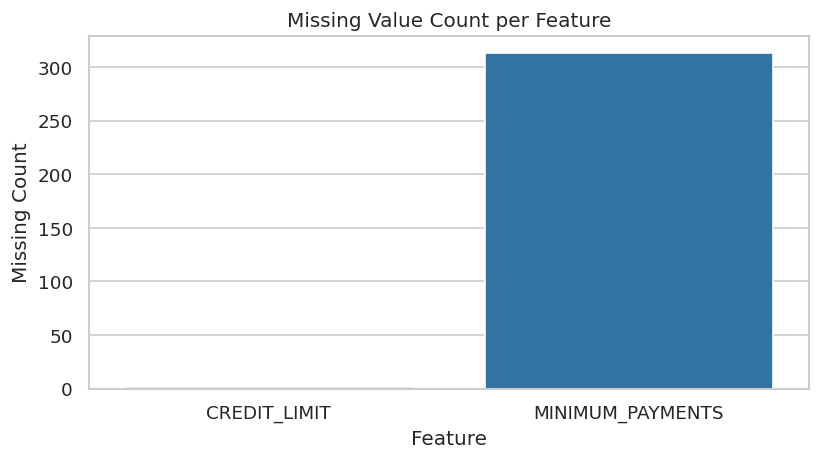

In [868]:
missing = df.isnull().sum()
missing = missing[missing > 0]
print('Missing values:')
print(missing)

missing_df = missing.reset_index()
missing_df.columns = ['Feature', 'Missing Count']

fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=df[missing.index].isnull().melt(var_name='Feature', value_name='Missing')
              .query('Missing == True'),
              x='Feature', ax=ax)
ax.set_title('Missing Value Count per Feature')
ax.set_xlabel('Feature')
ax.set_ylabel('Missing Count')

plt.tight_layout()
plt.show()

**Business Insight:** Only 2 features have missing values: `CREDIT_LIMIT` (1 missing, ~0.01%) and `MINIMUM_PAYMENTS` (313 missing, ~3.5%). Since both are right-skewed, median imputation preserves the distribution without introducing bias.

In [869]:
cust_ids = df['CUST_ID'].copy()
df = df.drop(columns=['CUST_ID'])

imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print('Missing values after imputation:', df_imputed.isnull().sum().sum())

Missing values after imputation: 0


### 1.3 Feature Distributions & Skewness

In [870]:
skewness = df_imputed.skew().sort_values(ascending=False)
print('Feature skewness:')
print(skewness.to_string())

highly_skewed = skewness[skewness.abs() > 1].index.tolist()
print(f'\nHighly skewed features (|skew| > 1): {highly_skewed}')

Feature skewness:
MINIMUM_PAYMENTS                    13.852446
ONEOFF_PURCHASES                    10.045083
PURCHASES                            8.144269
INSTALLMENTS_PURCHASES               7.299120
PAYMENTS                             5.907620
CASH_ADVANCE_TRX                     5.721298
CASH_ADVANCE                         5.166609
PURCHASES_TRX                        4.630655
BALANCE                              2.393386
PRC_FULL_PAYMENT                     1.942820
CASH_ADVANCE_FREQUENCY               1.828686
ONEOFF_PURCHASES_FREQUENCY           1.535613
CREDIT_LIMIT                         1.522636
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
PURCHASES_FREQUENCY                  0.060164
BALANCE_FREQUENCY                   -2.023266
TENURE                              -2.943017

Highly skewed features (|skew| > 1): ['MINIMUM_PAYMENTS', 'ONEOFF_PURCHASES', 'PURCHASES', 'INSTALLMENTS_PURCHASES', 'PAYMENTS', 'CASH_ADVANCE_TRX', 'CASH_ADVANCE', 'PURCHASES_TRX', 'BALANCE', 'PRC_F

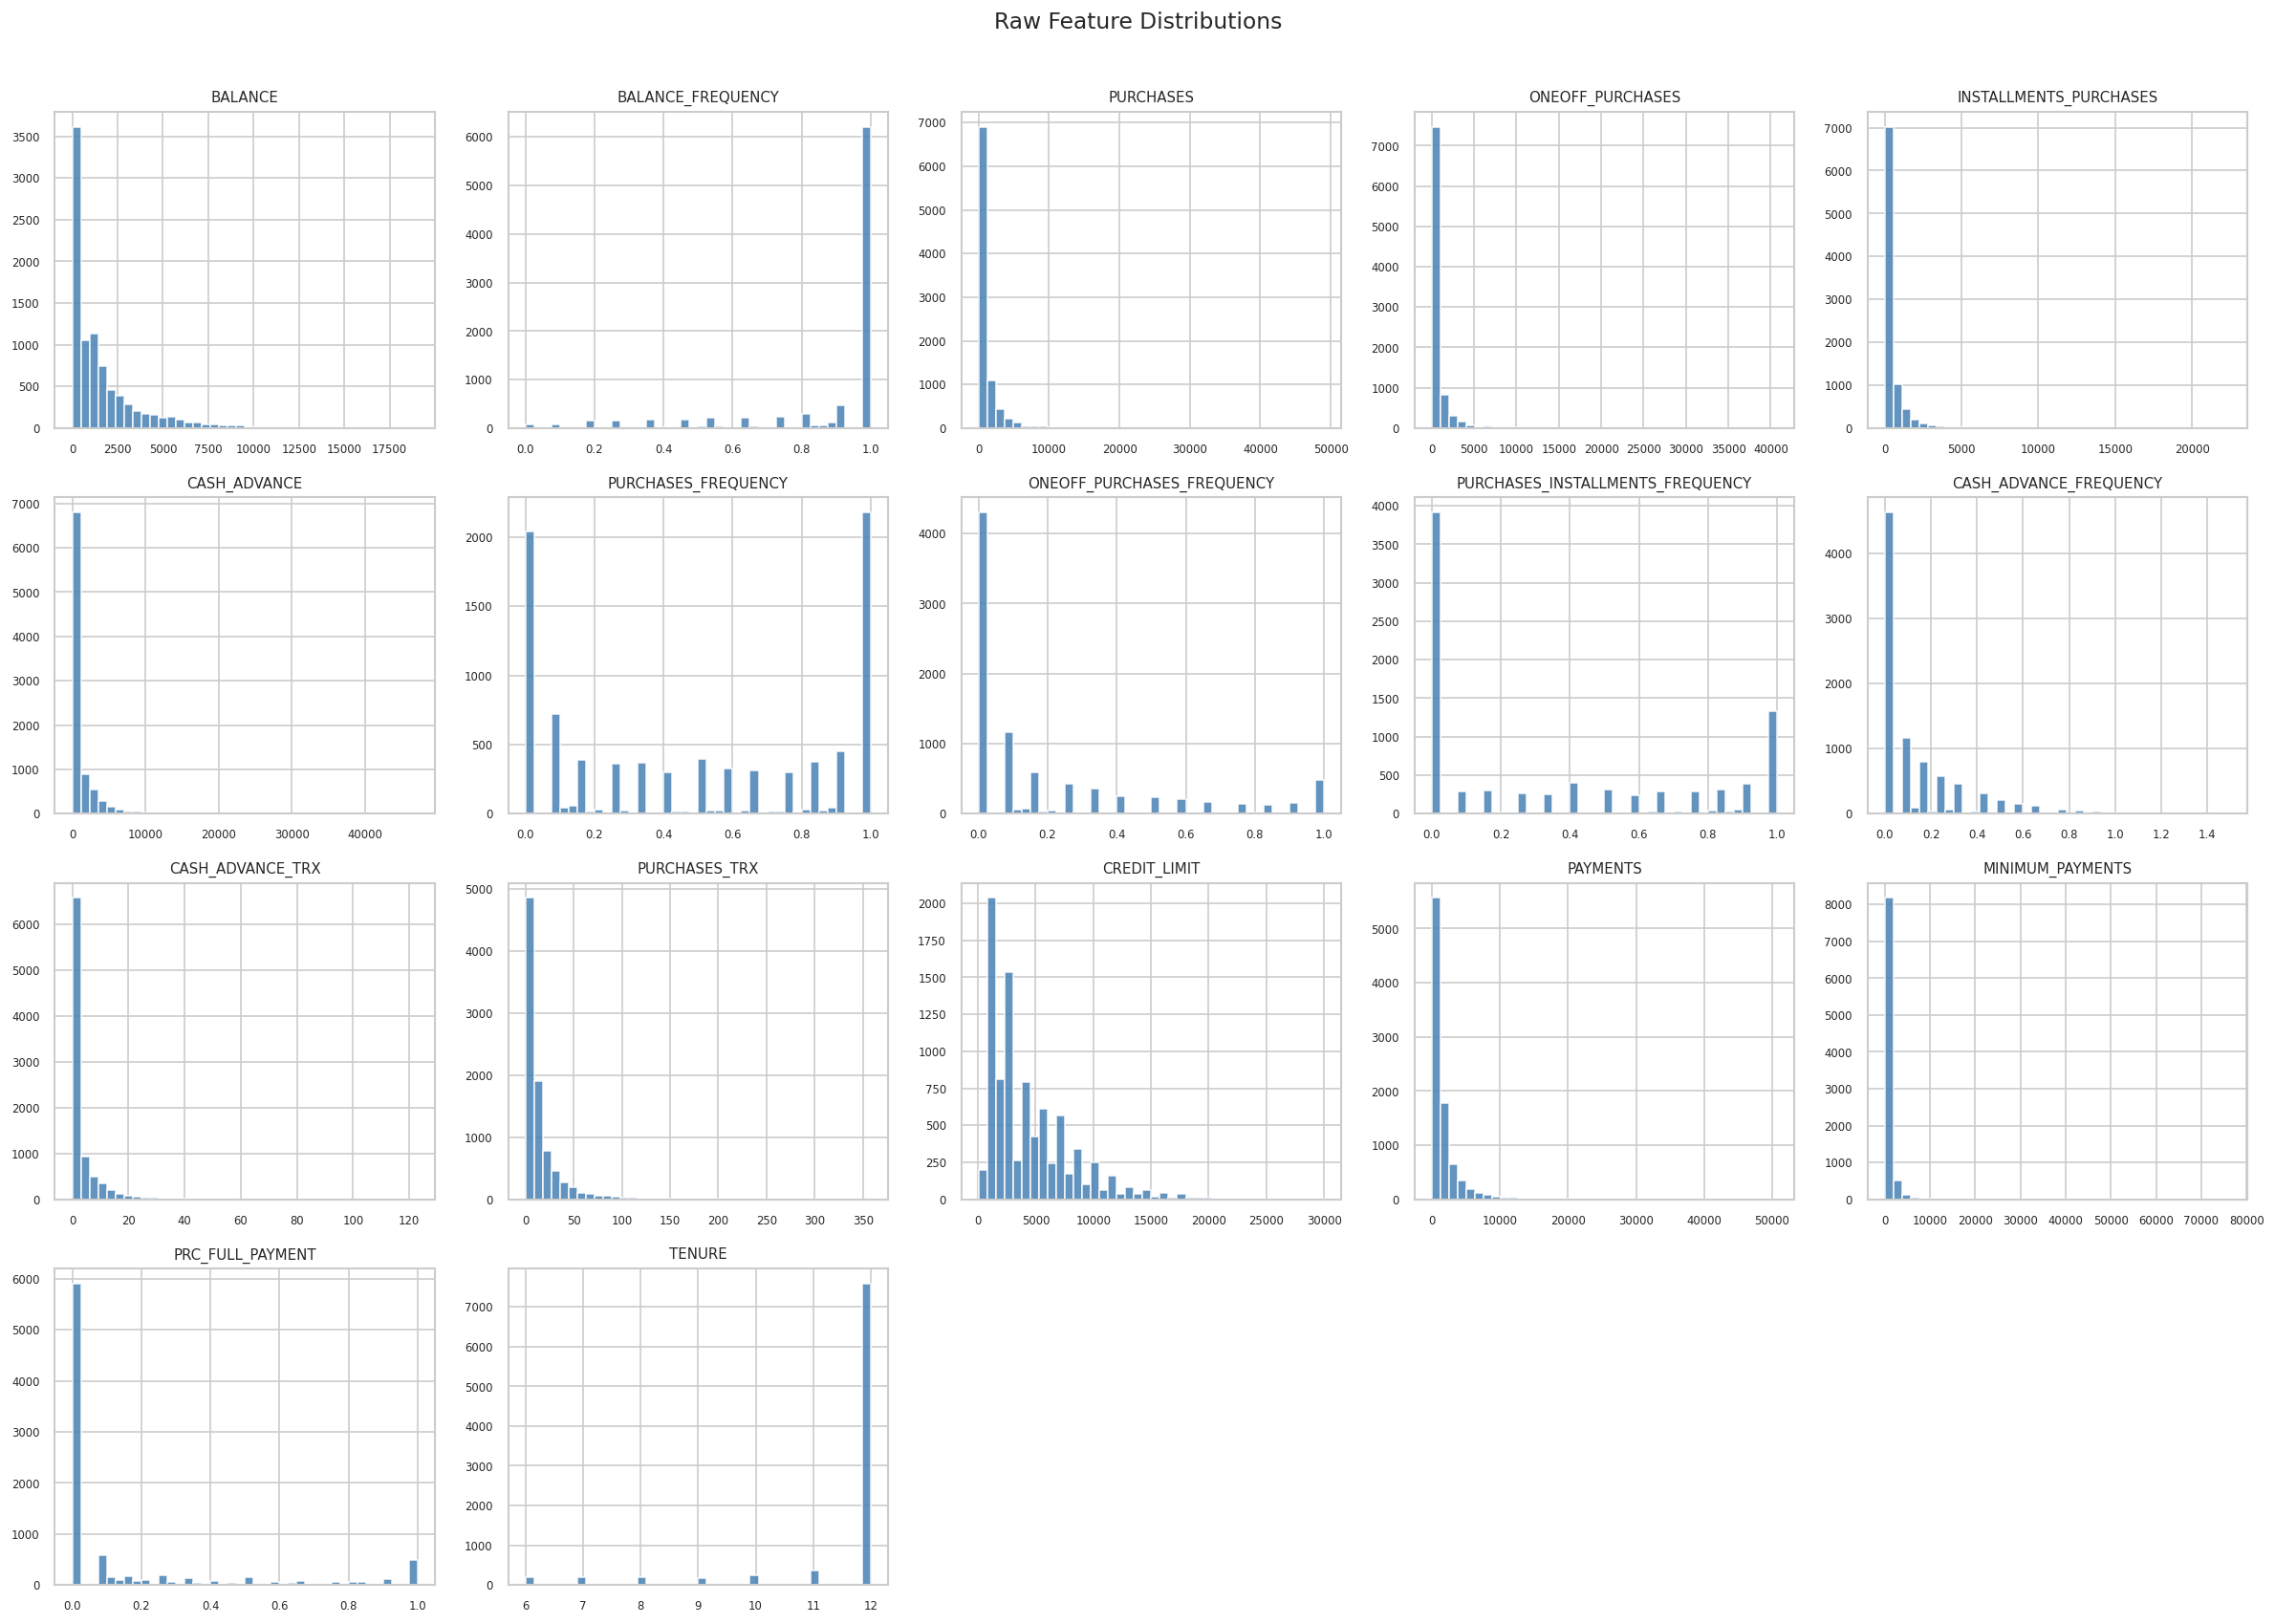

In [871]:
fig, axes = plt.subplots(4, 5, figsize=(20, 14))
axes = axes.flatten()
cols = df_imputed.columns.tolist()

for i, col in enumerate(cols):
    axes[i].hist(df_imputed[col], bins=40, color='steelblue', edgecolor='white', alpha=0.85)
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(labelsize=7)

for j in range(len(cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Raw Feature Distributions', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

**Business Insight:** Some features (`BALANCE`, `PURCHASES`, `CASH_ADVANCE`, `PAYMENTS`) are heavily right-skewed — the majority of customers have low-to-moderate values while a small minority drives extreme values. Log1p transformation is applied to compress this skew and prevent high-value customers from dominating the clustering.

### 1.4 Correlation Analysis

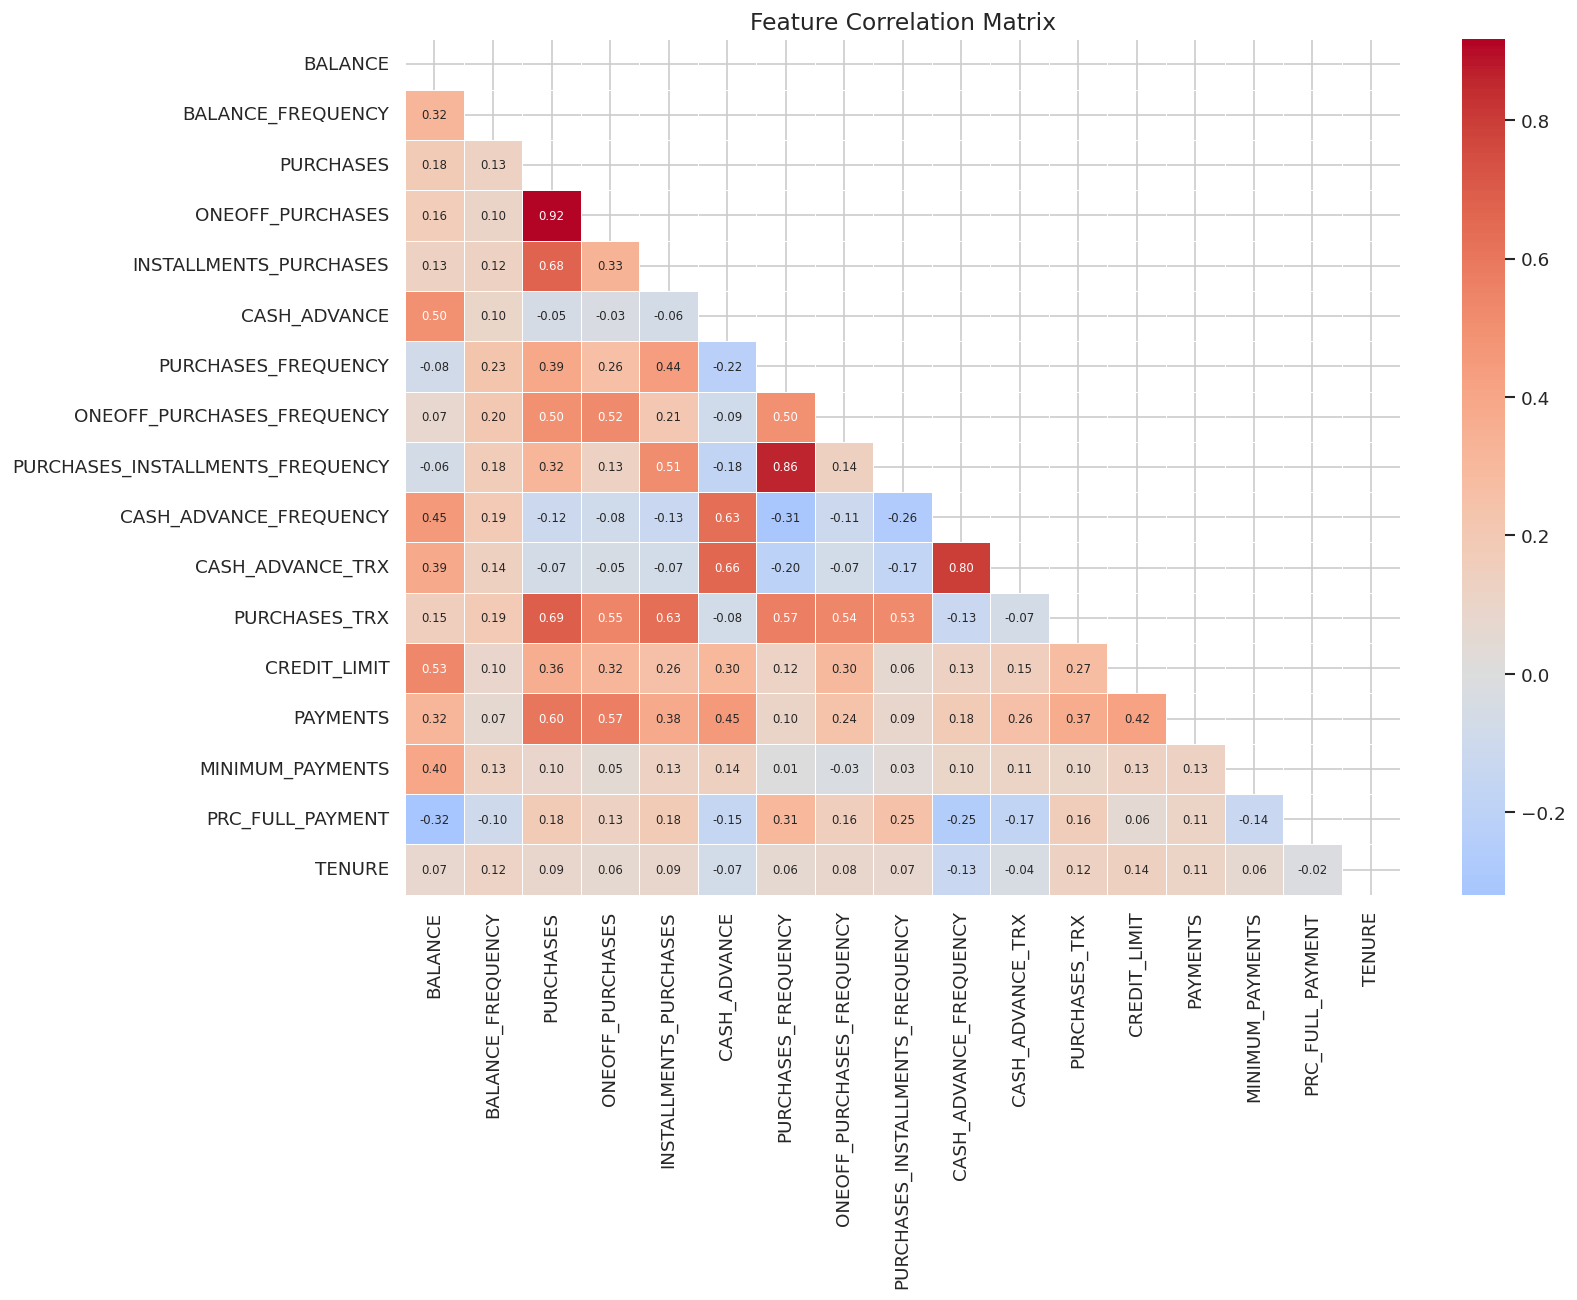

In [872]:
corr = df_imputed.corr()

fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, ax=ax, annot_kws={'size': 7})
ax.set_title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

**Business Insight:** `PURCHASES` and `ONEOFF_PURCHASES` are strongly correlated (r≈0.92), meaning one-off purchases make up most of total purchases for many customers. Similarly, `PURCHASES_FREQUENCY` and `PURCHASES_INSTALLMENTS_FREQUENCY` correlate at r≈0.86. Keeping both in each pair adds redundant information — PCA collapses these correlated features into fewer components.

### 1.5 Outlier Detection

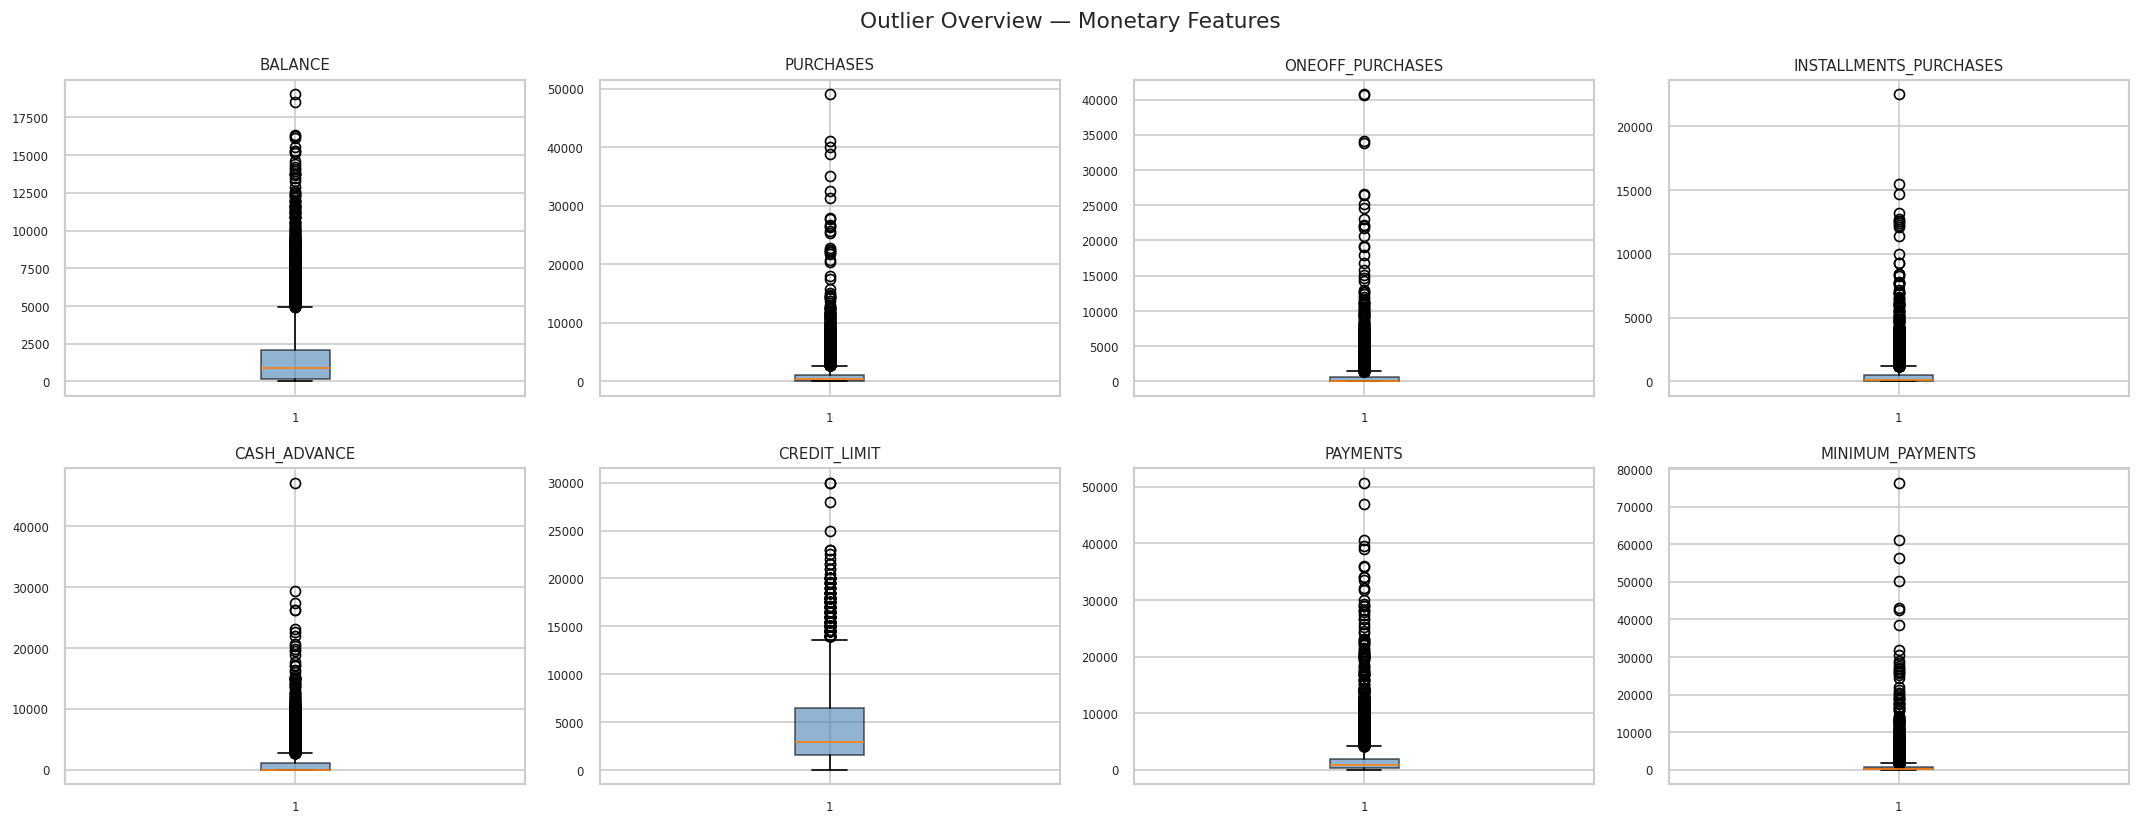

In [873]:
monetary_cols = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
                 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

fig, axes = plt.subplots(2, 4, figsize=(18, 7))
axes = axes.flatten()
for i, col in enumerate(monetary_cols):
    axes[i].boxplot(df_imputed[col], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.6))
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(labelsize=7)

plt.suptitle('Outlier Overview — Monetary Features', fontsize=13)
plt.tight_layout()
plt.show()

**Business Insight:** Extreme outliers in `CASH_ADVANCE` (some customers borrowing over $40,000) and `CREDIT_LIMIT` (up to $30,000) are not data errors — they represent real VIP and high-risk customer segments. Removing them would eliminate entire behavioral groups. Log transformation compresses their scale while keeping them in the dataset.

### 1.6 Preprocessing — Log Transform

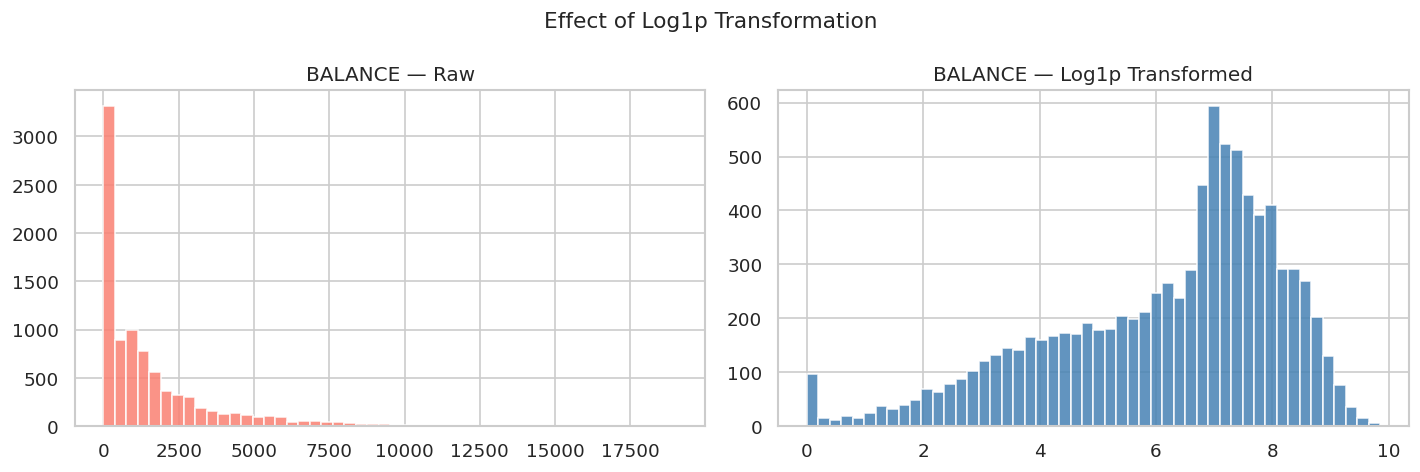

Feature matrix shape: (8950, 17)


In [874]:
df_log = df_imputed.copy()

log_cols = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
            'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS',
            'CASH_ADVANCE_TRX', 'PURCHASES_TRX']

for col in log_cols:
    df_log[col] = np.log1p(df_log[col])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df_imputed['BALANCE'], bins=50, color='salmon', edgecolor='white', alpha=0.85)
axes[0].set_title('BALANCE — Raw')
axes[1].hist(df_log['BALANCE'], bins=50, color='steelblue', edgecolor='white', alpha=0.85)
axes[1].set_title('BALANCE — Log1p Transformed')
plt.suptitle('Effect of Log1p Transformation', fontsize=13)
plt.tight_layout()
plt.show()

X_scaled = df_log.copy()
print(f'Feature matrix shape: {X_scaled.shape}')

### 1.7 Dimensionality Reduction — PCA

Components to explain 95% variance: 6


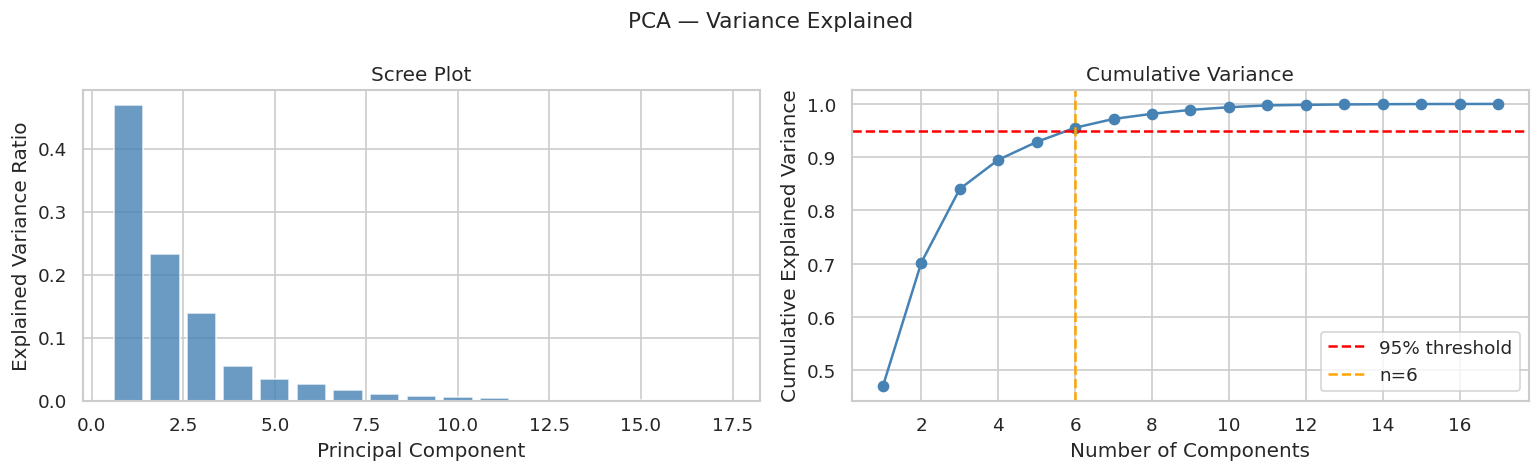

PCA matrix shape: (8950, 6)
Total variance retained: 0.955


In [875]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cum_var >= 0.95) + 1
print(f'Components to explain 95% variance: {n_components}')

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1),
            pca_full.explained_variance_ratio_, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')

axes[1].plot(range(1, len(cum_var)+1), cum_var, marker='o', color='steelblue')
axes[1].axhline(0.95, color='red', linestyle='--', label='95% threshold')
axes[1].axvline(n_components, color='orange', linestyle='--', label=f'n={n_components}')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()

plt.suptitle('PCA — Variance Explained', fontsize=13)
plt.tight_layout()
plt.show()

pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print(f'PCA matrix shape: {X_pca.shape}')
print(f'Total variance retained: {pca.explained_variance_ratio_.sum():.3f}')

---
## Phase 2 — Determining Optimal Number of Clusters

In [876]:
K_RANGE = range(2, 11)

inertia, sil_scores = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=RANDOM_STATE)
    labels_km = km.fit_predict(X_pca)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels_km))
    print(f'k={k:2d}  inertia={inertia[-1]:.0f}  silhouette={sil_scores[-1]:.4f}')

print('Done.')

k= 2  inertia=290787  silhouette=0.3706
k= 3  inertia=214367  silhouette=0.3796
k= 4  inertia=161004  silhouette=0.4010
k= 5  inertia=131575  silhouette=0.4209
k= 6  inertia=112908  silhouette=0.4313
k= 7  inertia=101037  silhouette=0.4477
k= 8  inertia=93773  silhouette=0.4061
k= 9  inertia=87372  silhouette=0.3487
k=10  inertia=82687  silhouette=0.3355
Done.


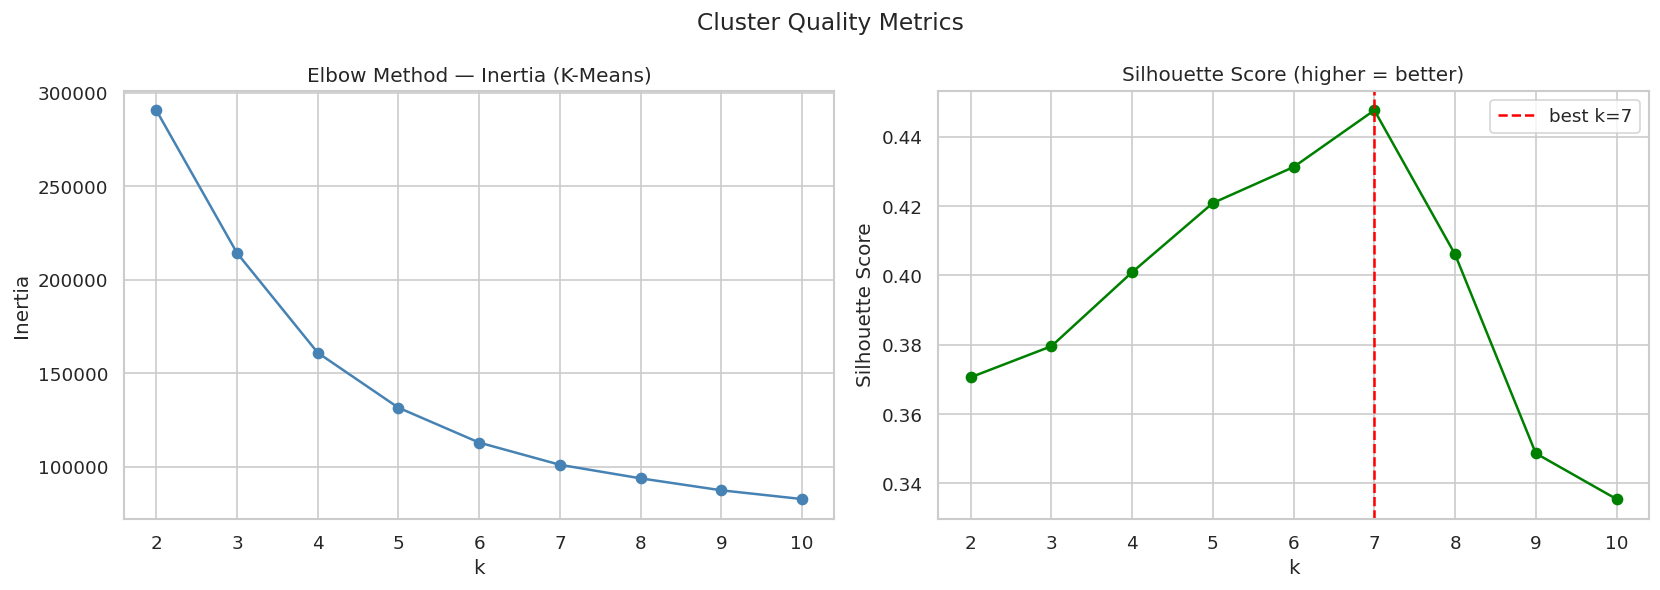

Best k by Silhouette: 7


In [877]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ks = list(K_RANGE)

# Elbow plot
axes[0].plot(ks, inertia, marker='o', color='steelblue')
axes[0].set_title('Elbow Method — Inertia (K-Means)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')

# Silhouette plot
axes[1].plot(ks, sil_scores, marker='o', color='green')
axes[1].set_title('Silhouette Score (higher = better)')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')
best_sil_k = ks[np.argmax(sil_scores)]
axes[1].axvline(best_sil_k, color='red', linestyle='--', label=f'best k={best_sil_k}')
axes[1].legend()

plt.suptitle('Cluster Quality Metrics', fontsize=14)
plt.tight_layout()
plt.show()

print(f'Best k by Silhouette: {best_sil_k}')

In [878]:
ks          = list(K_RANGE)
ks_arr      = np.array(ks)
inertia_arr = np.array(inertia)
sil_arr     = np.array(sil_scores)

second_deriv = np.diff(inertia_arr, 2)
elbow_k = ks[np.argmax(second_deriv) + 1]
sil_k   = ks[np.argmax(sil_arr)]

print(f'Elbow point : k = {elbow_k}')
print(f'Best Silhouette score at    : k = {sil_k}')

candidates       = sorted(set([elbow_k, sil_k]))
best_candidate_k = max(candidates, key=lambda k: sil_arr[ks.index(k)])
OPTIMAL_K        = best_candidate_k

print(f'\n==> Chosen OPTIMAL_K = {OPTIMAL_K}')
print(f'\nJustification:')
print(f'  Elbow method suggests k={elbow_k}')
print(f'  Silhouette score is best at k={sil_k}')
print(f'  Chosen k={OPTIMAL_K} based on best silhouette among candidates.')

Elbow point : k = 4
Best Silhouette score at    : k = 7

==> Chosen OPTIMAL_K = 7

Justification:
  Elbow method suggests k=4
  Silhouette score is best at k=7
  Chosen k=7 based on best silhouette among candidates.


---
## Phase 3 — Customer Segmentation

### 3.1 K-Means Model

In [879]:
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=50,
                max_iter=500, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

df_clustered = df_imputed.copy()
df_clustered['Cluster'] = cluster_labels

print(f'Cluster distribution:')
print(df_clustered['Cluster'].value_counts().sort_index())
print(f'\nFinal Silhouette Score: {silhouette_score(X_pca, cluster_labels):.4f}')

Cluster distribution:
Cluster
0    1633
1    2068
2    1895
3     938
4     798
5    1138
6     480
Name: count, dtype: int64

Final Silhouette Score: 0.4477


### 3.2 GMM Comparison

In [880]:
gmm_final = GaussianMixture(n_components=OPTIMAL_K, covariance_type='full',
                             n_init=10, random_state=RANDOM_STATE)
gmm_labels = gmm_final.fit_predict(X_pca)

print('GMM cluster distribution:')
print(pd.Series(gmm_labels).value_counts().sort_index())
print(f'\nGMM Silhouette Score   : {silhouette_score(X_pca, gmm_labels):.4f}')
print(f'K-Means Silhouette Score: {silhouette_score(X_pca, cluster_labels):.4f}')

GMM cluster distribution:
0    1369
1     459
2    1071
3    1978
4    1603
5     669
6    1801
Name: count, dtype: int64

GMM Silhouette Score   : 0.3259
K-Means Silhouette Score: 0.4477


In [881]:
km_sil  = silhouette_score(X_pca, cluster_labels)
gmm_sil = silhouette_score(X_pca, gmm_labels)

if km_sil >= gmm_sil:
    final_labels = cluster_labels
    chosen_model = 'K-Means'
else:
    final_labels = gmm_labels
    chosen_model = 'GMM'

df_clustered['Cluster'] = final_labels
print(f'Proceeding with: {chosen_model} (Silhouette = {max(km_sil, gmm_sil):.4f})')

Proceeding with: K-Means (Silhouette = 0.4477)


### 3.3 Cluster Profiles

In [882]:
profile = df_clustered.groupby('Cluster').agg(['mean', 'median', 'std']).round(2)
profile

BALANCE                   BALANCE_FREQUENCY              PURCHASES  \
            mean   median      std              mean median   std      mean   
Cluster                                                                       
0        1313.82   599.04  1903.05              0.95    1.0  0.13   2682.88   
1        2151.04  1453.27  2119.21              0.88    1.0  0.23      0.10   
2         364.89    53.34   789.88              0.78    1.0  0.30    498.72   
3        2932.11  2135.58  2633.39              0.97    1.0  0.09   2067.51   
4        2353.56  1649.89  2260.29              0.93    1.0  0.16    635.55   
5         746.76   236.48  1156.62              0.77    1.0  0.30    838.38   
6        2580.13  1653.70  2608.71              0.96    1.0  0.12    524.34   

                          ONEOFF_PURCHASES  ... PAYMENTS MINIMUM_PAYMENTS  \
          median      std             mean  ...      std             mean   
Cluster                                     ...                             
0        1684.29  3618.67          1628.94  ...  3351.14           704.02   
1           0.00     1.16             0.07  ...  2746.49           976.67   
2         315.02   636.34             3.13  ...  1234.11           611.33   
3        1344.34  2671.67          1254.83  ...  4361.60          1281.20   
4         298.24  1290.20           634.37  ...  2588.72          1003.21   
5         433.54  1288.65           836.39  ...  2258.67           471.20   
6         329.30   832.20             2.33  ...  2860.74          1448.89   

                         PRC_FULL_PAYMENT              TENURE               
         median      std             mean median   std   mean median   std  
Cluster                                                                     
0        227.35  2543.83             0.26    0.0  0.36  11.83   12.0  0.75  
1        469.70  2557.29             0.04    0.0  0.14  11.32   12.0  1.55  
2        166.02  2616.56             0.30    0.1  0.37  11.50   12.0  1.39  
3        788.61  1790.01             0.07    0.0  0.18  11.65   12.0  1.14  
4        538.92  1650.92             0.05    0.0  0.15  11.30   12.0  1.58  
5        204.42  1547.48             0.14    0.0  0.29  11.56   12.0  1.27  
6        796.91  2524.51             0.04    0.0  0.12  11.34   12.0  1.57  

[7 rows x 51 columns]

In [883]:
cluster_means = df_clustered.groupby('Cluster').mean().round(2)
cluster_means

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster,,,,,,,,,,,,,,,,,
0,1313.82,0.95,2682.88,1628.94,1053.97,0.26,0.84,0.48,0.67,0.00,0.01,37.14,5879.05,2456.52,704.02,0.26,11.83
1,2151.04,0.88,0.10,0.07,0.08,1994.34,0.00,0.00,0.00,0.27,6.29,0.03,4031.95,1659.04,976.67,0.04,11.32
2,364.89,0.78,498.72,3.13,496.55,0.25,0.70,0.01,0.66,0.00,0.00,11.50,3113.13,712.69,611.33,0.30,11.50
3,2932.11,0.97,2067.51,1254.83,812.70,2199.92,0.80,0.41,0.65,0.30,7.99,31.90,5963.50,3219.03,1281.20,0.07,11.65
4,2353.56,0.93,635.55,634.37,1.59,2022.68,0.28,0.28,0.01,0.30,6.95,6.29,4615.57,1872.29,1003.21,0.05,11.30
5,746.76,0.77,838.38,836.39,2.07,0.77,0.36,0.35,0.01,0.00,0.02,7.42,4411.92,1154.23,471.20,0.14,11.56
6,2580.13,0.96,524.34,2.33,522.63,1994.15,0.65,0.01,0.60,0.26,6.21,12.05,4350.31,1857.57,1448.89,0.04,11.34


In [884]:
SEGMENT_MAP = {
    0: 'Big Spenders (VIP)',
    1: 'Cash-Only Dependents',
    2: 'Installment Shoppers',
    3: 'High-Risk Heavy Users',
    4: 'One-off & Cash Advance Revolvers',
    5: 'One-off Shoppers',
    6: 'Installment & Cash Advance Revolvers',
}

if len(cluster_means) != 7:
    SEGMENT_MAP = {i: f'Segment {i}' for i in cluster_means.index}

segment_names = {i: SEGMENT_MAP.get(i, f'Segment {i}') for i in cluster_means.index}
df_clustered['Segment'] = df_clustered['Cluster'].map(segment_names)

print('Cluster -> Segment mapping:')
for k, v in segment_names.items():
    n = (df_clustered['Cluster'] == k).sum()
    print(f'  Cluster {k}: {v:45s}  ({n:5d} customers, {n/len(df_clustered)*100:.1f}%)')

Cluster -> Segment mapping:
  Cluster 0: Big Spenders (VIP)                             ( 1633 customers, 18.2%)
  Cluster 1: Cash-Only Dependents                           ( 2068 customers, 23.1%)
  Cluster 2: Installment Shoppers                           ( 1895 customers, 21.2%)
  Cluster 3: High-Risk Heavy Users                          (  938 customers, 10.5%)
  Cluster 4: One-off & Cash Advance Revolvers               (  798 customers, 8.9%)
  Cluster 5: One-off Shoppers                               ( 1138 customers, 12.7%)
  Cluster 6: Installment & Cash Advance Revolvers           (  480 customers, 5.4%)


---
## Phase 4 — Visualization & Analysis

### 4.1 t-SNE 2D Cluster Visualization

Running t-SNE


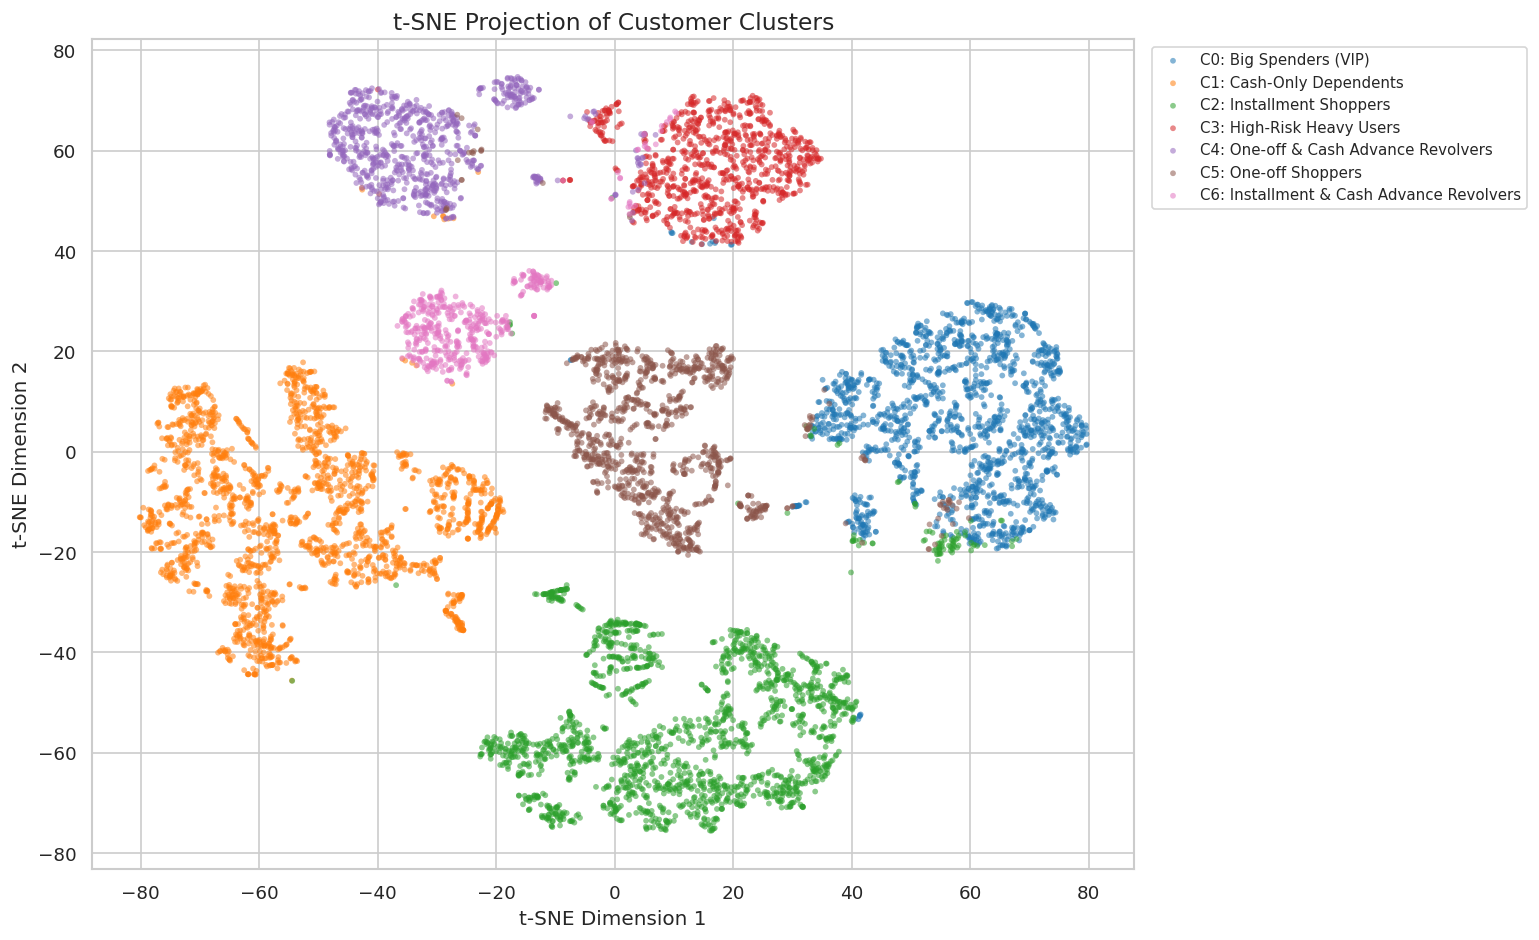

In [885]:
print('Running t-SNE')
tsne = TSNE(n_components=2, perplexity=40, max_iter=1000,
            learning_rate='auto', init='pca', random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = final_labels
tsne_df['Segment'] = df_clustered['Segment'].values

fig, ax = plt.subplots(figsize=(13, 8))
palette = sns.color_palette('tab10', OPTIMAL_K)

for cid in sorted(tsne_df['Cluster'].unique()):
    mask = tsne_df['Cluster'] == cid
    ax.scatter(tsne_df.loc[mask, 'TSNE1'], tsne_df.loc[mask, 'TSNE2'],
               c=[palette[cid]], label=f'C{cid}: {segment_names[cid]}',
               alpha=0.55, s=12, edgecolors='none')

ax.set_title('t-SNE Projection of Customer Clusters', fontsize=14)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

**Business Insight:** The 7 clusters appear as clearly separated color blobs with minimal overlap, consistent with a silhouette score of 0.4477. Any overlap between adjacent clusters (e.g. C3 and C0) reflects customers who share partial behaviors — such as high purchases in both groups.

### 4.2 Cluster Size Distribution

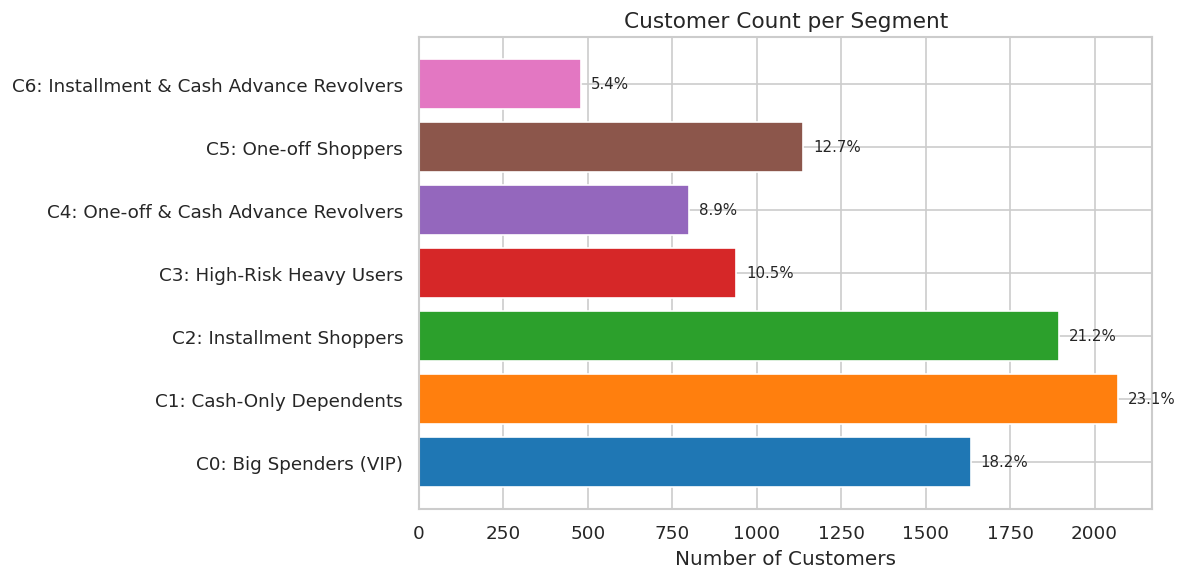

In [888]:
size_df = df_clustered.groupby(['Cluster', 'Segment']).size().reset_index(name='Count')
size_df['Pct'] = (size_df['Count'] / len(df_clustered) * 100).round(1)
size_df['Label'] = size_df.apply(lambda r: f"C{r['Cluster']}: {r['Segment']}", axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(size_df['Label'], size_df['Count'],
               color=[palette[c] for c in size_df['Cluster']], edgecolor='white')
for bar, pct in zip(bars, size_df['Pct']):
    ax.text(bar.get_width() + 30, bar.get_y() + bar.get_height()/2,
            f'{pct}%', va='center', fontsize=9)
ax.set_xlabel('Number of Customers')
ax.set_title('Customer Count per Segment', fontsize=13)
plt.tight_layout()
plt.show()

**Business Insight:** The largest segment is **C1 Cash-Only Dependents (23.1%, 2,068 customers)** — customers who carry high balances but make virtually no purchases. This is the bank's highest-risk concentration. The smallest segment is **C6 Installment & Cash Advance Revolvers (5.4%, 480 customers)** — financially complex group requiring specialized risk monitoring.

### 4.3 Feature Distributions by Cluster (Key Features)

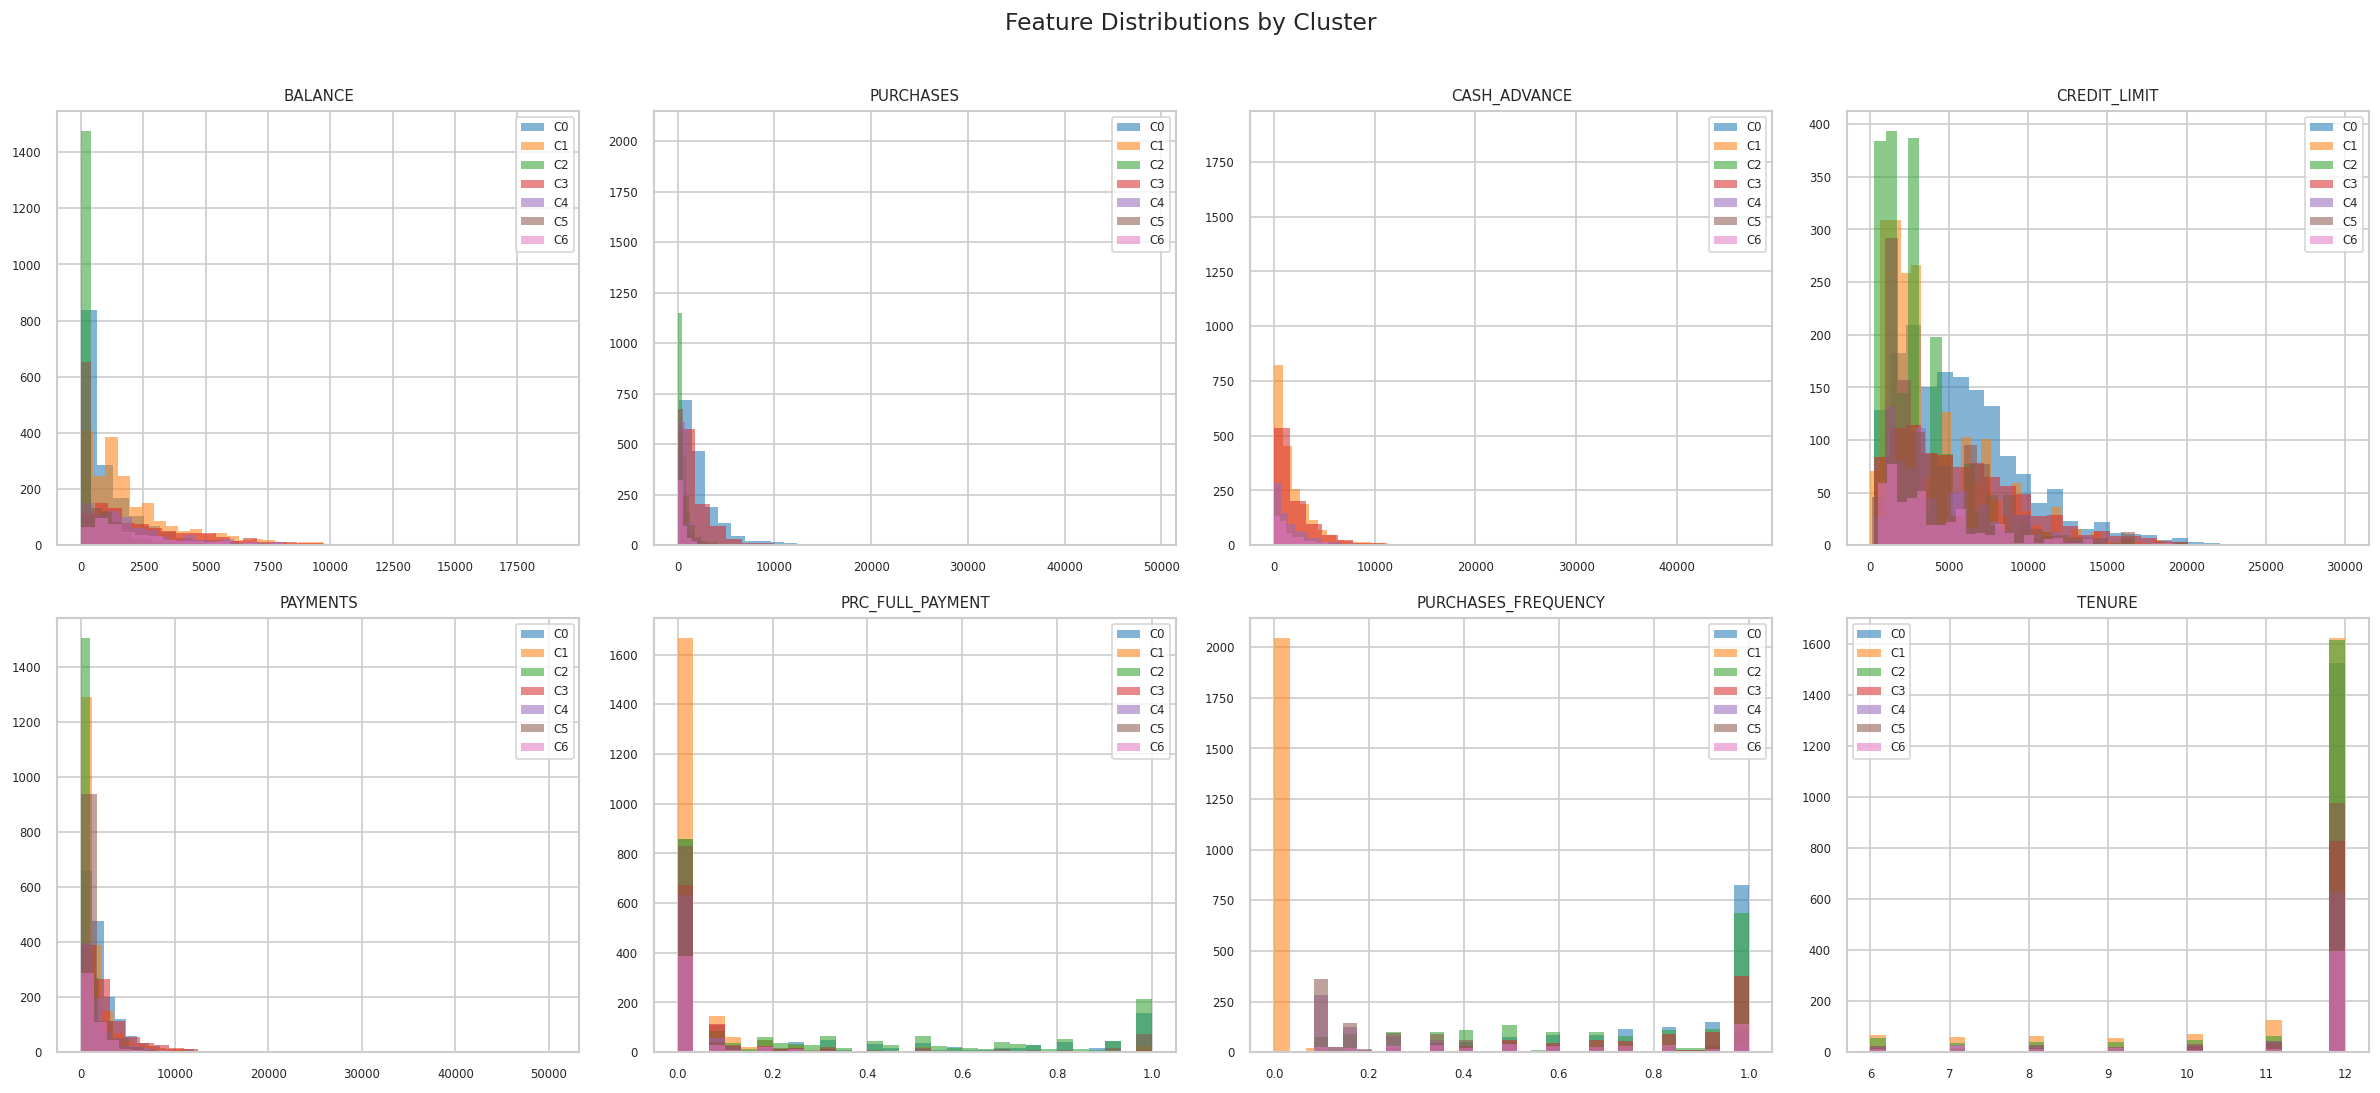

In [889]:
key_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
                'PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY', 'TENURE']

fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()

for i, feat in enumerate(key_features):
    for cid in sorted(df_clustered['Cluster'].unique()):
        data = df_clustered.loc[df_clustered['Cluster'] == cid, feat]
        axes[i].hist(data, bins=30, alpha=0.55, label=f'C{cid}',
                     color=palette[cid], edgecolor='none')
    axes[i].set_title(feat, fontsize=9)
    axes[i].tick_params(labelsize=7)
    axes[i].legend(fontsize=7)

plt.suptitle('Feature Distributions by Cluster', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

**Business Insight:** `PURCHASES` and `CASH_ADVANCE` provide the clearest cluster separation — C1 spikes at exactly zero for purchases while C0 spreads far right. `TENURE` shows almost complete overlap across all clusters, confirming it plays no meaningful role in differentiating customer behavior. `PRC_FULL_PAYMENT` is near zero for most clusters, with only C2 (Installment Shoppers) showing any rightward spread — the only segment with a tendency to pay in full.

### 4.4 Cluster Heatmap — Mean Feature Values

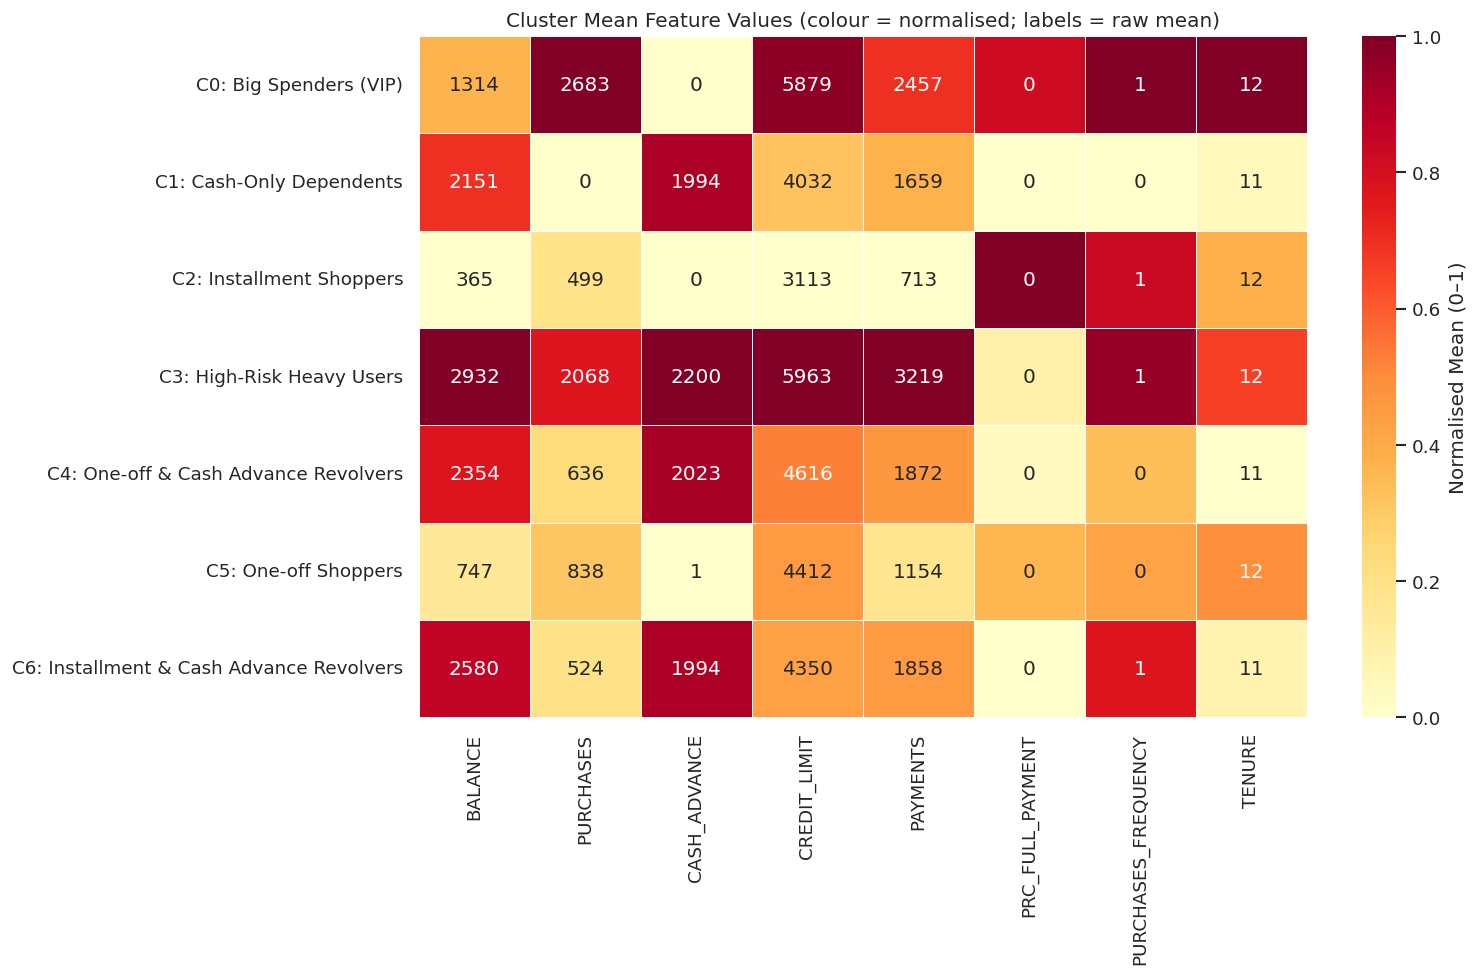

In [890]:
means      = df_clustered.groupby('Cluster')[key_features].mean()
means_norm = (means - means.min()) / (means.max() - means.min() + 1e-9)

means_norm.index = [f'C{i}: {segment_names[i]}' for i in means_norm.index]

fig, ax = plt.subplots(figsize=(13, OPTIMAL_K * 0.9 + 2))
sns.heatmap(means_norm, annot=means.values.round(0), fmt='.0f',
            cmap='YlOrRd', linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Normalised Mean (0–1)'})
ax.set_title('Cluster Mean Feature Values (colour = normalised; labels = raw mean)', fontsize=12)
plt.tight_layout()
plt.show()

**Business Insight:** C3 (High-Risk Heavy Users) is the darkest row across `BALANCE`, `CASH_ADVANCE`, and `PAYMENTS` simultaneously — the most financially active and highest-risk segment. C2 (Installment Shoppers) is the lightest row overall — lowest activity with zero cash advance usage. The `PRC_FULL_PAYMENT` column is meaningfully above zero only for C2, confirming it is the only segment with a tendency to pay balances in full.

### 4.5 Radar Chart — Cluster Fingerprints

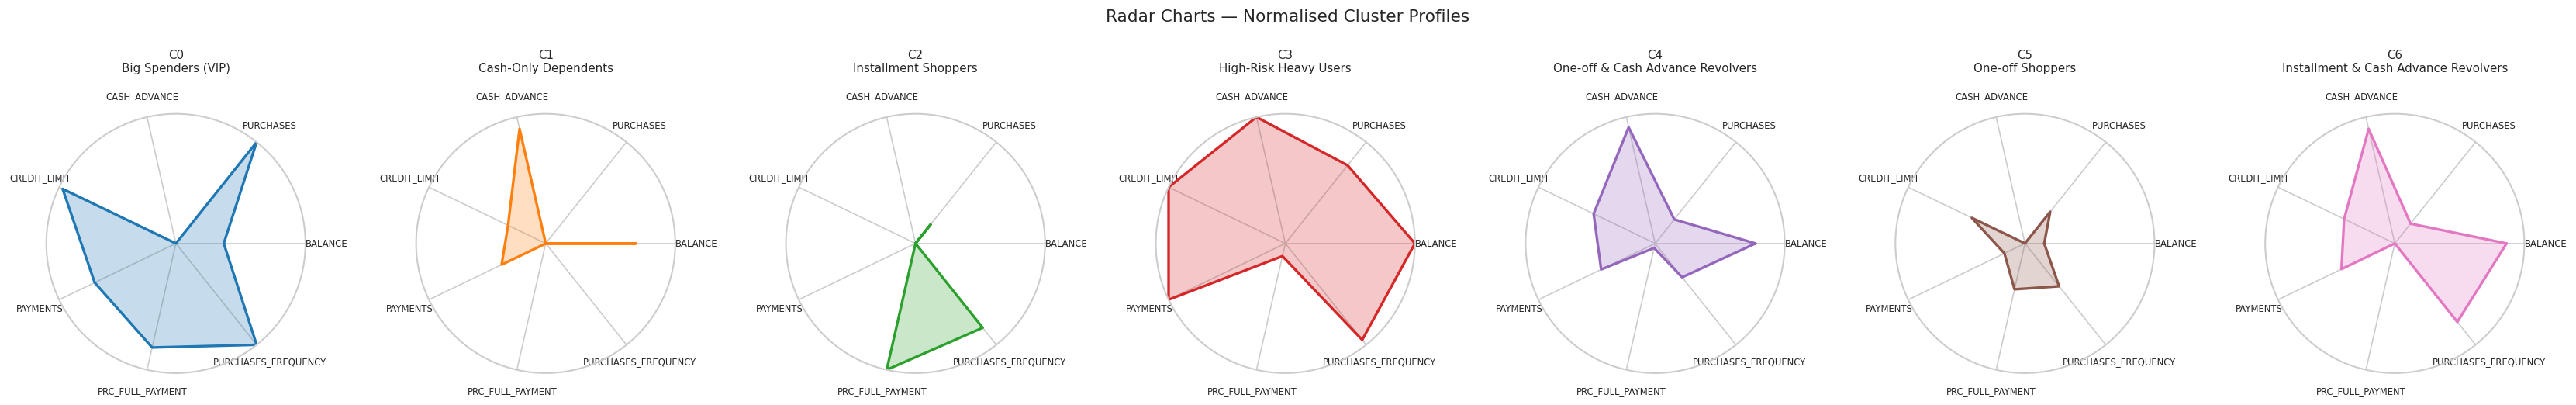

In [891]:
radar_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
                  'PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY']

radar_data = df_clustered.groupby('Cluster')[radar_features].mean()
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min() + 1e-9)

N      = len(radar_features)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(1, OPTIMAL_K,
                          figsize=(4 * OPTIMAL_K, 4),
                          subplot_kw=dict(polar=True))
if OPTIMAL_K == 1:
    axes = [axes]

for cid, ax in enumerate(axes):
    values = radar_norm.iloc[cid].tolist() + radar_norm.iloc[cid].tolist()[:1]
    ax.plot(angles, values, color=palette[cid], linewidth=2)
    ax.fill(angles, values, color=palette[cid], alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features, size=7)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_title(f'C{cid}\n{segment_names[cid]}', size=9, pad=15)

plt.suptitle('Radar Charts — Normalised Cluster Profiles', fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

**Business Insight:** C3 (High-Risk Heavy Users) has the largest radar polygon, spiking in multiple directions simultaneously — the only cluster combining high `PURCHASES`, `CASH_ADVANCE`, and `BALANCE`. C1 (Cash-Only Dependents) has a highly asymmetric shape — large only on `CASH_ADVANCE` and `BALANCE`, completely flat on `PURCHASES`. C2 (Installment Shoppers) has the smallest polygon overall, reflecting the lowest financial activity across all features.

### 4.6 Box Plots — Key Financial Features by Segment

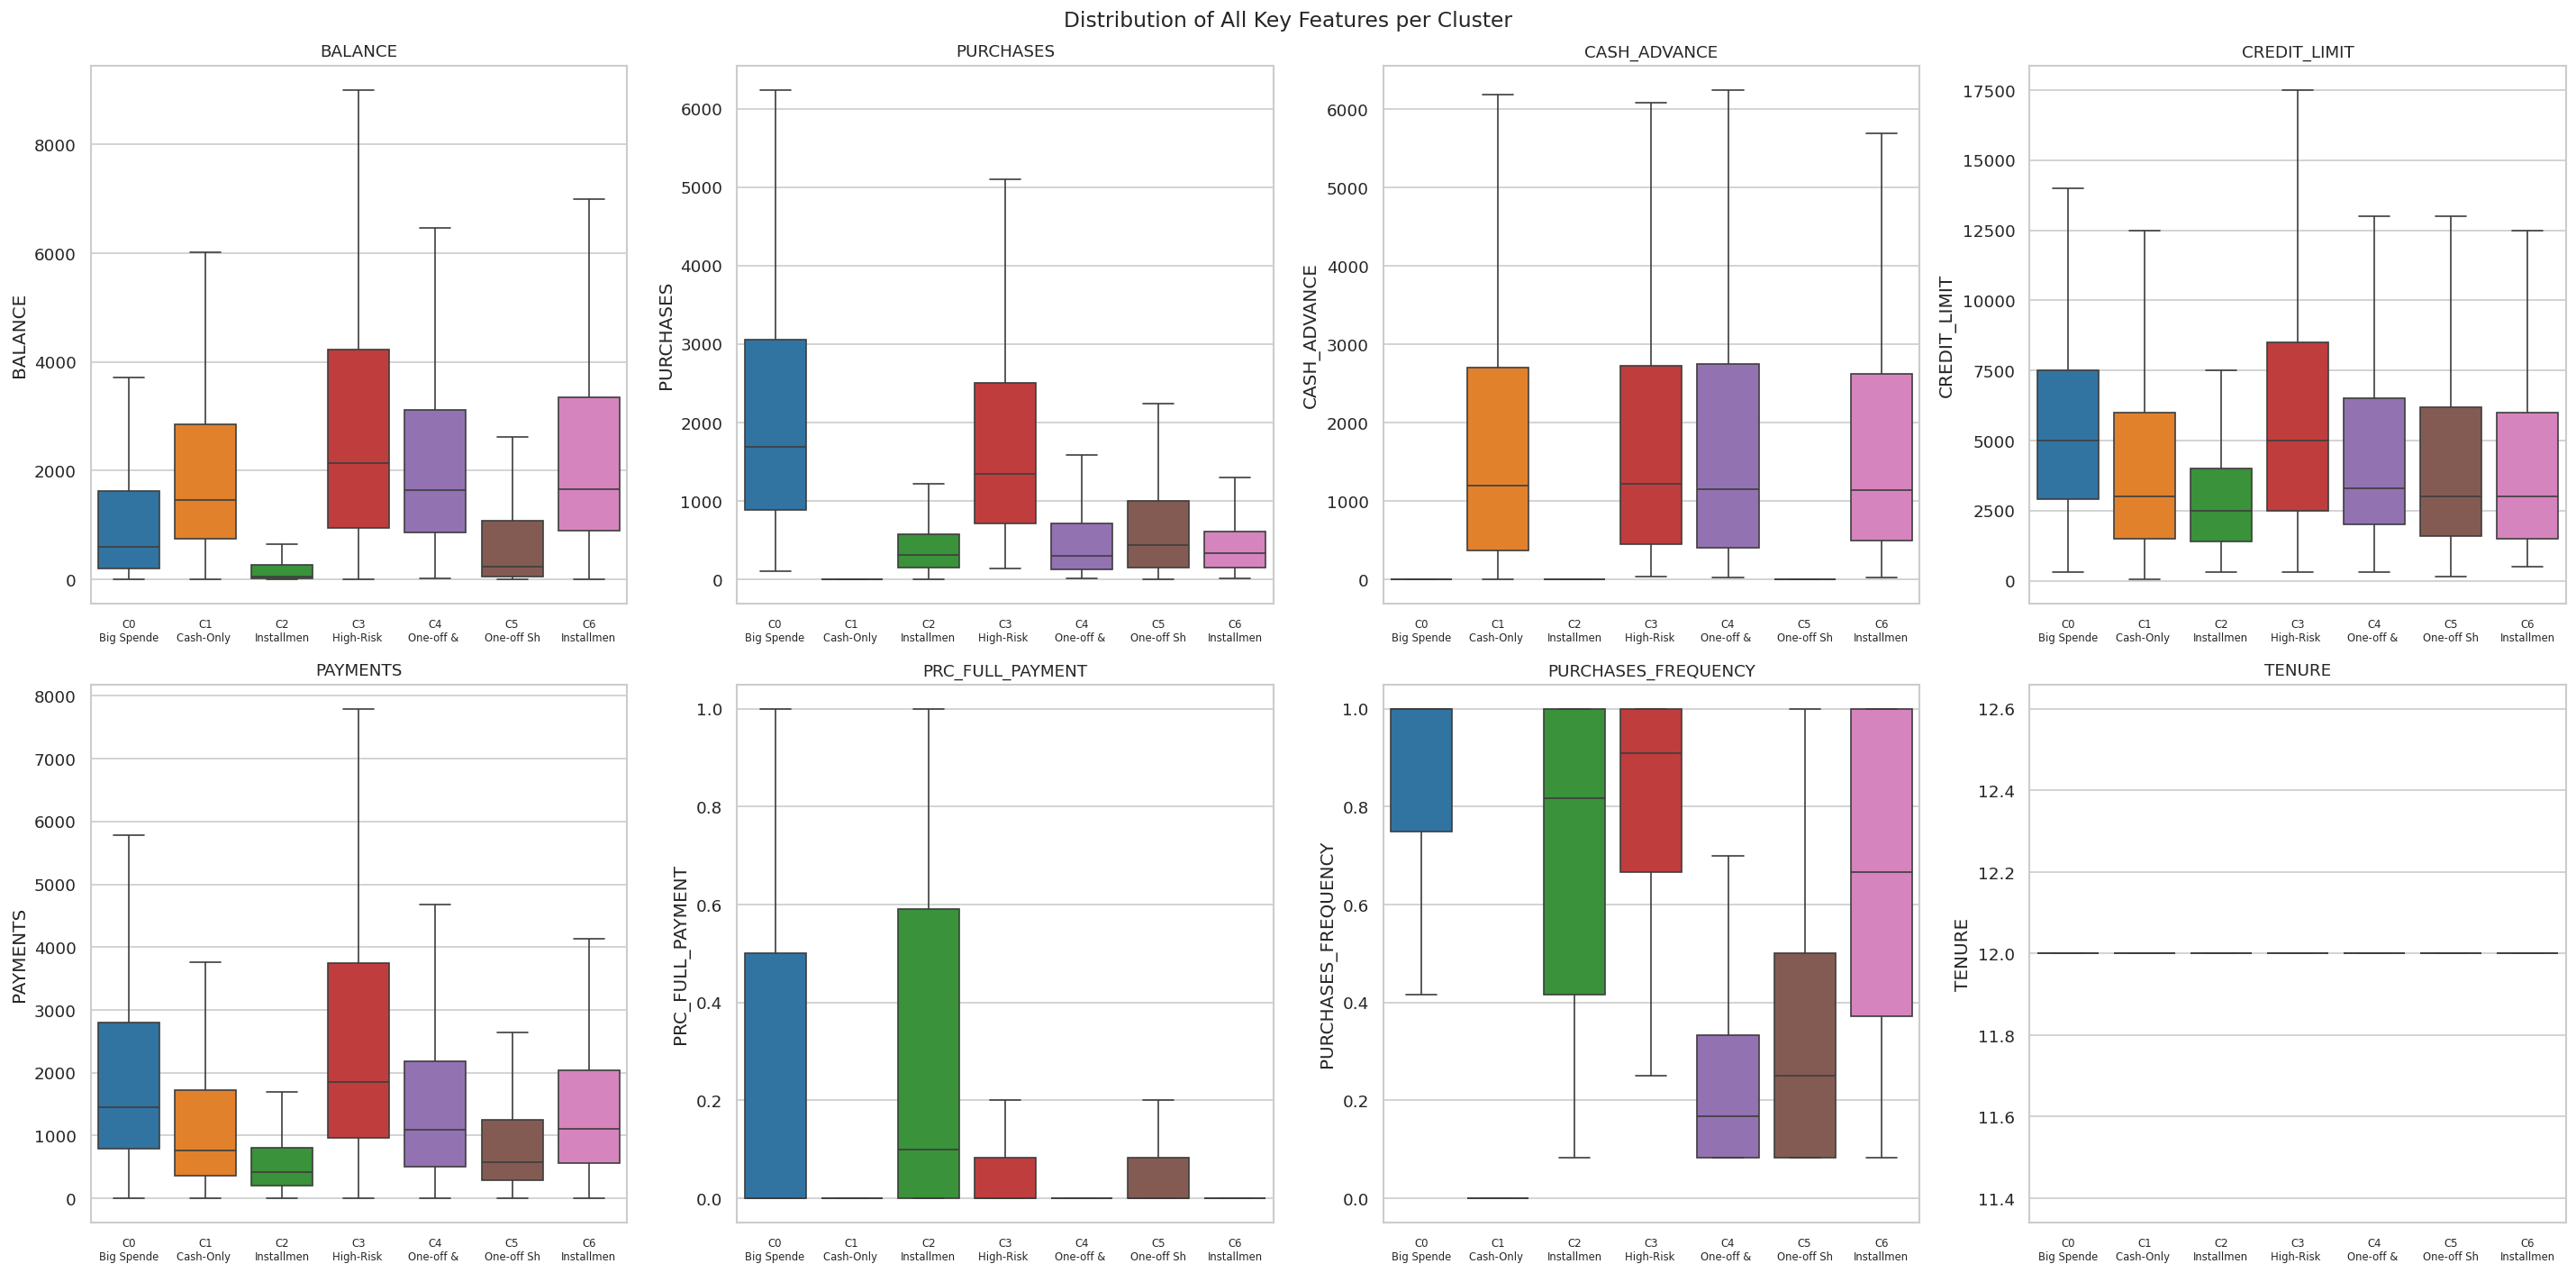

In [897]:
box_feats = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
             'PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY', 'TENURE']

df_plot = df_clustered.copy()
df_plot['Segment_short'] = df_plot['Cluster'].map(lambda x: f'C{x}')
order = [f'C{c}' for c in sorted(df_plot['Cluster'].unique())]
tick_labels = [f'C{c}\n{segment_names[c][:10]}' for c in sorted(df_plot['Cluster'].unique())]

fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

for i, feat in enumerate(box_feats):
    sns.boxplot(data=df_plot, x='Segment_short', y=feat,
                palette=palette[:OPTIMAL_K], ax=axes[i],
                order=order, showfliers=False)
    axes[i].set_title(feat, fontsize=11)
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(tick_labels, fontsize=7)

plt.suptitle('Distribution of All Key Features per Cluster',
             fontsize=14)
plt.tight_layout()
plt.show()

**Business Insight:** Across all 8 features:
- **`BALANCE`** — C3 and C6 have the highest and widest boxes, confirming heavy debt carriers. C2 sits near zero with a narrow box — consistently low balance.
- **`PURCHASES`** — C0 has the highest median and widest box (high variability within VIPs). C1 has a flat box at zero — every customer in this segment truly never purchases.
- **`CASH_ADVANCE`** — C1, C3, C4, C6 all have elevated boxes. C0 and C2 sit at zero — these segments never use cash advance.
- **`CREDIT_LIMIT`** — C0 and C3 have the highest limits, reflecting the bank rewarding high spenders and heavy users with more credit.
- **`PAYMENTS`** — Mirrors purchases closely; C0 and C3 pay the most, consistent with their high spending.
- **`PRC_FULL_PAYMENT`** — Almost all clusters have boxes near zero. C2 is the only segment with a visible spread upward — the only group that partially pays in full.
- **`PURCHASES_FREQUENCY`** — C0 has a high narrow box near 1.0 (buys every month consistently). C1 has a flat box at 0.0 (never buys). The sharpest contrast of all features.
- **`TENURE`** — All clusters have nearly identical boxes, confirming that tenure does not distinguish customer behavior in any meaningful way.

### 4.7 Segment Summary Table

In [894]:
summary_feats = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
                 'PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY',
                 'CASH_ADVANCE_FREQUENCY', 'TENURE']

summary = df_clustered.groupby('Cluster')[summary_feats].mean().round(1)
summary.insert(0, 'Segment Name', [segment_names[c] for c in summary.index])
summary.insert(1, 'Size', df_clustered.groupby('Cluster').size().values)
summary.insert(2, 'Size %', (summary['Size'] / len(df_clustered) * 100).round(1))

print('=== FINAL CLUSTER PROFILES ===')
display(summary.style.background_gradient(cmap='YlOrRd',
        subset=['BALANCE','PURCHASES','CASH_ADVANCE','CREDIT_LIMIT','PAYMENTS','PRC_FULL_PAYMENT']))

=== FINAL CLUSTER PROFILES ===


,Segment Name,Size,Size %,BALANCE,PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,TENURE
Cluster,,,,,,,,,,,,
0,Big Spenders (VIP),1633,18.200000,1313.800000,2682.900000,0.300000,5879.000000,2456.500000,0.300000,0.800000,0.000000,11.800000
1,Cash-Only Dependents,2068,23.100000,2151.000000,0.100000,1994.300000,4031.900000,1659.000000,0.000000,0.000000,0.300000,11.300000
2,Installment Shoppers,1895,21.200000,364.900000,498.700000,0.300000,3113.100000,712.700000,0.300000,0.700000,0.000000,11.500000
3,High-Risk Heavy Users,938,10.500000,2932.100000,2067.500000,2199.900000,5963.500000,3219.000000,0.100000,0.800000,0.300000,11.600000
4,One-off & Cash Advance Revolvers,798,8.900000,2353.600000,635.600000,2022.700000,4615.600000,1872.300000,0.100000,0.300000,0.300000,11.300000
5,One-off Shoppers,1138,12.700000,746.800000,838.400000,0.800000,4411.900000,1154.200000,0.100000,0.400000,0.000000,11.600000
6,Installment & Cash Advance Revolvers,480,5.400000,2580.100000,524.300000,1994.100000,4350.300000,1857.600000,0.000000,0.700000,0.300000,11.300000
